# **MIDAS Task 1**

For this task, two different methods are tested and evaluated. The methods differ mainly on the audio feature used for classification. They are listed below as:
1. Using Normalized Log Spectrogram of Audio Samples
2. Using MFCC's and their higher order Deltas

**This notebook only has the first method, which gavebest results. The other method is in the other experiments, placed in the experiments folder. This notebook has:**
* Libraries Required
* Data Unzip
* Data Check
* EDA
* Data Loading, Preprocessing, Feature Extraction
* Training andTesting

References:

1. David S., Speech representation and Data Exploration: Has been used to better understand the data

# Libraries

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import random
from os.path import isdir, join
import regex as re
import gc
import sklearn
import pickle

import librosa
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd 

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, Conv1D
from sklearn.model_selection import train_test_split
import keras

import warnings
warnings.filterwarnings("ignore")

# Data Unzip

In [2]:
!apt-get install -y p7zip-full
!7z x ../input/tensorflow-speech-recognition-challenge/train.7z
!7z x ../input/tensorflow-speech-recognition-challenge/test.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  p7zip
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip p7zip-full
0 upgraded, 2 newly installed, 0 to remove and 23 not upgraded.
Need to get 1522 kB of archives.
After this operation, 5755 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip-full amd64 16.02+dfsg-6 [1164 kB]
Fetched 1522 kB in 3s (606 kB/s)      
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 95165 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Selecting previously unselected package p7zip-full.
Preparin

In [3]:
'''
Check Training Audio Folder
'''

train_audio_path = 'train/audio/'
print(len(os.listdir(train_audio_path)))
print(os.listdir(train_audio_path))

31
['cat', 'up', 'nine', 'no', 'bird', 'left', 'zero', 'yes', 'off', 'bed', 'six', 'four', 'three', 'right', 'marvin', 'tree', 'seven', 'eight', 'wow', 'down', 'dog', 'five', 'on', 'go', 'stop', '_background_noise_', 'one', 'two', 'happy', 'sheila', 'house']


## Exploratory Data Analysis

The following Features are Visualised:

1. Raw Audio
2. MFCCs
3. First and Second Order Deltas of MFCCs

**These features will be considered for the feature set**

In [4]:
'''
Loading a sample file to study
'''

# At 8000 
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples2, sample_rate2 = librosa.load(str(train_audio_path) + filename, 8000)

# At 16000 
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path) + filename, 16000)
print('Sample Rate: ', sample_rate)
print()
ipd.Audio(samples, rate=sample_rate)

Sample Rate:  16000



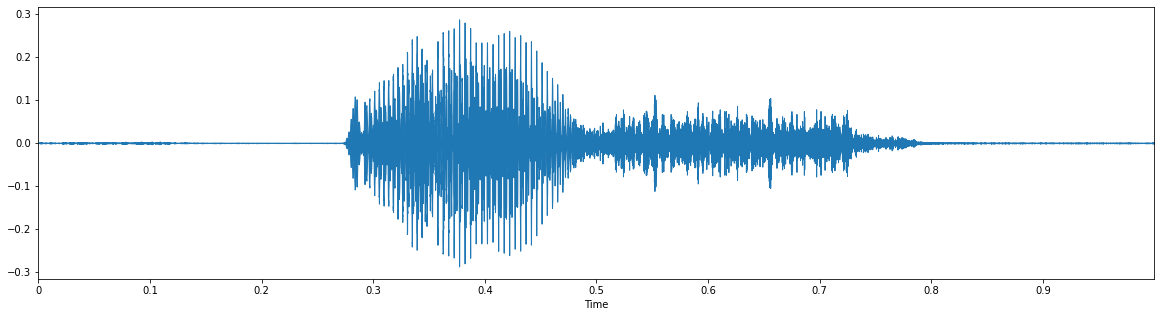

In [5]:
'''
Plotting Raw Data
'''

plt.figure(figsize=(20, 5))
librosa.display.waveplot(samples, sr=16000)

#### MFCCs (First 13)

(13, 32)


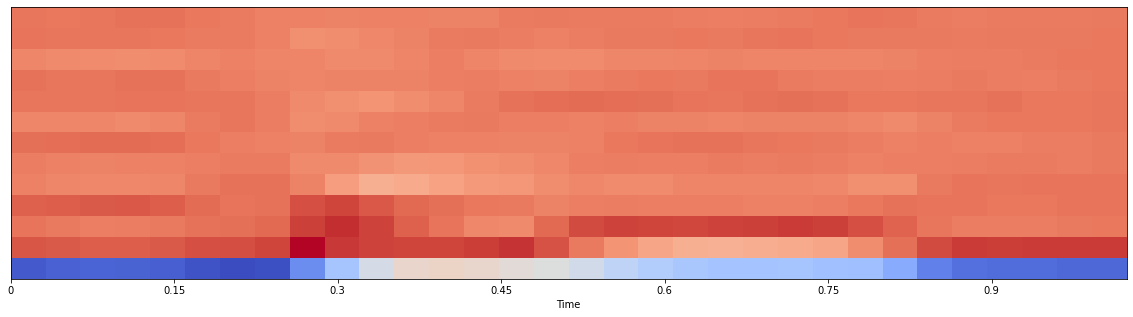

In [8]:
'''
This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. 
The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.
'''

plt.figure(figsize=(20,5))
mfcc = librosa.feature.mfcc(samples, sr=16000, n_mfcc=13)
print(mfcc.shape)

librosa.display.specshow(mfcc, sr=16000, x_axis='time')

#### First and Second Order Deltas of MFCCs (First 13)

(13, 32)


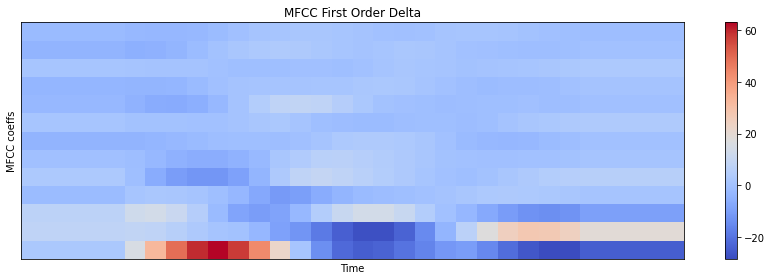

In [9]:
'''
Deltas are just the nth order derivative of the MFCCs. The provide a simpler overview of the sample.
'''

delta1_mfcc = librosa.feature.delta(mfcc, order=1)
print(delta1_mfcc.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta1_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC First Order Delta')
plt.colorbar()
plt.tight_layout()

(13, 32)


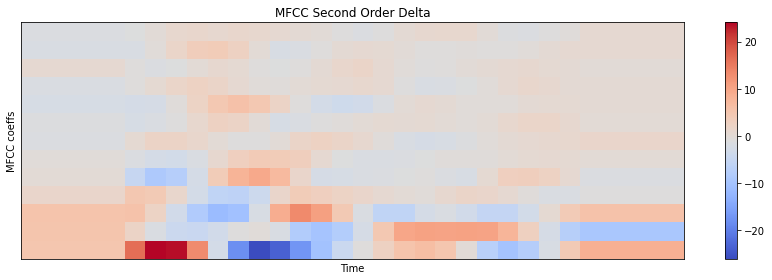

In [10]:
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC Second Order Delta')
plt.colorbar()
plt.tight_layout()

In [18]:
'''
Example of final stacked feature set
'''

features = np.concatenate((mfcc, delta1_mfcc, delta2_mfcc), axis=0)

print(features.shape)

(39, 32)


## Data Loading, Preprocessing and Feature Extraction

##### Details:

1. All files are sampled at 16000 HZ
2. The file length has been kept constant at 1 second.
2. Zero Padding has been used in sound processing to make audio files of same length. The same has been implemented here.
3. For extremely long audio files, they have been split into smaller 1 second samples.

##### Features

1. MFCCs and its first and second order deltas are loaded.
2. These are stacked to create the feature set.

In [12]:
'''
Variables to load data.

sr - Sample Rate
Legal Labels - Categories to Classify
'''

sr = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

# Paths
train_data_path = 'train/audio'
test_data_path = 'test'

# Path Helper
ext = 'wav'

In [13]:
'''
Utility Function

Task - Collect all file names.
'''

def collect_files(path):
    
    # Simple Regex to collect paths
    fpaths = glob(os.path.join(path, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    
    labels = []
    for fpath in fpaths:
        fpath = fpath.replace('\\', '/')
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        fpath = fpath.replace('\\', '/')
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [14]:
'''
Get paths and labels.
'''

labels, filenames = collect_files(train_data_path)

In [15]:
'''
Padding -> Pad smaller samples with 0

Reduce -> Reduce audio to predefined size.

Labellize -> Tranform label to suitable format for model.
'''

def padding(samples):
    if len(samples) >= sr: 
        return samples
    else: 
        return np.pad(samples, pad_width=(sr - len(samples), 0), mode='constant', constant_values=(0, 0))

def reduce(samples, sr=16000, num=20):
    for i in range(num):
        cut = np.random.randint(0, len(samples) - sr)
        yield samples[cut: cut + sr]

def labellize(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [19]:
'''
Load MFCCS
'''

Y_tr = []
X_tr = []

for label, fname in tqdm(zip(labels, filenames)):
    
    samples, sample_rate = librosa.load(os.path.join(train_data_path, label, fname), sr = 16000)
    samples = padding(samples)
    if len(samples) > 16000:
        n_samples = reduce(samples)
    else: 
        n_samples = [samples]
    for samples in n_samples:
        
        # Feature Extraction
        mfcc = librosa.feature.mfcc(samples, sr = 16000, n_mfcc = 13)
        delta1 = librosa.feature.delta(mfcc, order=1)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        features = np.concatenate((mfcc, delta1, delta2), axis=0)
        
        Y_tr.append(label)
        X_tr.append(features)

64727it [14:24, 74.91it/s]


In [20]:
'''
Converting to Numpy Arrays and labellizing.
'''

X_train = np.array(X_tr)
X_train = X_train.reshape(tuple(list(X_train.shape) + [1]))
Y_train = labellize(Y_tr)
label_index = Y_train.columns.values
Y_train = Y_train.values
Y_train = np.array(Y_train)
del labels, filenames, X_tr, Y_tr
gc.collect()

25728

## Training

* Batch Normalization used to normalize all spectrogram.
* Max Pooling and Dropout used to prevent over-fitting.
* Simple Convolution Layer Used. 
* A heavy model was not used since RAM was limited to 16GB on kaggle.

In [21]:
'''
Define Params
'''

input_shape = (39, 32, 1)
nclass = 12
inp = Input(shape=input_shape)

In [22]:
'''
Build Model
'''

norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=5, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=5, activation=activations.relu)(norm_inp)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=2, activation=activations.relu)(img_1)
img_1 = Convolution2D(32, kernel_size=2, activation=activations.relu)(img_1)
img_1 = Dropout(rate=0.3)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(64, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(64, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 39, 32, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 39, 32, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 28, 8)         208       
_________________________________________________________________
dropout (Dropout)            (None, 35, 28, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 26, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 24, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 24, 16)        0     

In [23]:
'''
Split into train and validation and run.
'''

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=1)
model.fit(X_train, Y_train, batch_size=32, validation_data=(X_valid, Y_valid), epochs=20, shuffle=True)

Epoch 1/20
1824/1824 [==============================] - 120s 65ms/step - loss: 0.2781 - accuracy: 0.6002 - val_loss: 0.0701 - val_accuracy: 0.8574
Epoch 2/20
1824/1824 [==============================] - 125s 68ms/step - loss: 0.0715 - accuracy: 0.8435 - val_loss: 0.0500 - val_accuracy: 0.8999
Epoch 3/20
1824/1824 [==============================] - 117s 64ms/step - loss: 0.0563 - accuracy: 0.8782 - val_loss: 0.0514 - val_accuracy: 0.8919
Epoch 4/20
1824/1824 [==============================] - 118s 64ms/step - loss: 0.0483 - accuracy: 0.8987 - val_loss: 0.0428 - val_accuracy: 0.9109
Epoch 5/20
1824/1824 [==============================] - 118s 64ms/step - loss: 0.0436 - accuracy: 0.9076 - val_loss: 0.0395 - val_accuracy: 0.9187
Epoch 6/20
1824/1824 [==============================] - 119s 65ms/step - loss: 0.0384 - accuracy: 0.9211 - val_loss: 0.0426 - val_accuracy: 0.9120
Epoch 7/20
1824/1824 [==============================] - 118s 65ms/step - loss: 0.0372 - accuracy: 0.9215 - val_loss: 0

## Testing

In [24]:
'''
Create generator for test data. Since Data is too large.
'''

test_data_path = 'test/audio'

def test_data_generator(batch=16):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        samples, rate = librosa.load(path, sr = 16000)
        samples = padding(samples)
        
        mfcc = librosa.feature.mfcc(samples, sr = 16000, n_mfcc = 13)
        delta1 = librosa.feature.delta(mfcc, order=1)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        features = np.concatenate((mfcc, delta1, delta2), axis=0)
        
        imgs.append(features)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
            yield fnames, imgs
    if i < batch:
        imgs = np.array(imgs)
        imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
        yield fnames, imgs
    raise StopIteration()

In [25]:
'''
Clear RAM since Test Data is too large.
'''

del X_train, Y_train
gc.collect()

1883

In [26]:
'''
Test and store results in a dataframe.
'''

index = []
results = []

for fnames, specs in tqdm(test_data_generator(batch=32)):
    predicts = model.predict(specs)
    predicts = np.argmax(predicts, axis=1)
    predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)

4955it [42:47,  1.93it/s]


RuntimeError: generator raised StopIteration

In [27]:
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results

'''
Checking Format of Result and saving
'''

def cleanfname(s):
    lis = s.split('/')
    return str(lis[2])
    
df.fname = df.fname.apply(cleanfname)
df.to_csv('submission_deltas.csv', index=False)
df.head(20)

,fname,label
0,clip_17d93b95e.wav,go
1,clip_a955b4709.wav,unknown
2,clip_1da671640.wav,up
3,clip_68cb3b046.wav,unknown
4,clip_ba2a671f7.wav,left
5,clip_f6e33c03c.wav,unknown
6,clip_01087fbdb.wav,left
7,clip_995591165.wav,yes
8,clip_d751705cf.wav,unknown
9,clip_7d85b7001.wav,silence
